# Filter Design

## The preparation

First, we load a sample sound as an example for later experiments:

In [0]:
import wave

import numpy as np

with wave.open('blue-ocean-floor.wav', 'r') as wav:
    frame_rate, sample_width = wav.getframerate(), wav.getsampwidth()
    ocean = (lambda a: a/ a.max())(np.frombuffer(
        wav.readframes(wav.getnframes()), dtype=f'i{sample_width}'))

Then for convenience purposes, we define a few `matplotlib` wrappers:

In [0]:
from math import pi

import matplotlib.pyplot as plt
from numpy.fft import fft


def plt_time(sequence):
    """Plot the signal in time domain."""
    length = len(sequence)
    plt.plot(np.linspace(0, length/frame_rate, length), sequence)
    plt.show()


def plt_fft(sequence):
    """Plot the magnitude of the FT of the signal."""
    domain = np.linspace(0, pi*2, len(sequence))
    plt.plot(domain, np.abs(fft(sequence)))
    plt.show()


def plt_db(sequence):
    """Plot the FT of the signal in dB."""
    domain = np.linspace(0, pi*2, len(sequence))
    FT = fft(sequence)
    plt.plot(domain, 20 * np.log10(np.abs(FT/abs(FT).max())))
    plt.show()

The sample audio's waveform can then be visualized using

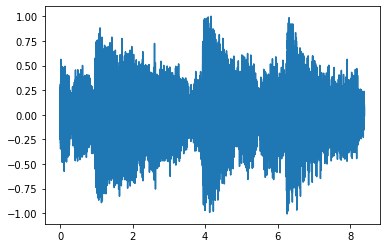

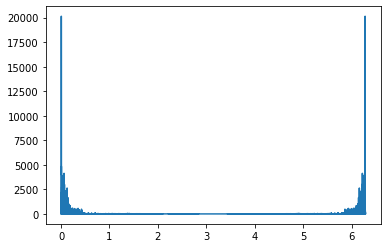

In [61]:
plt_time(ocean)
plt_fft(ocean)

It is completely normal that the audio is mainly low frequency, given the `frame_rate` of 44100 Hz, while vocal is around 300 to 1000 Hz and we can usually hear only up to around 10000 Hz.

In [9]:
print(frame_rate)

44100


## The sinc function

The ideal low pass filter has the impulse response of `h[n] = sin(w*n) / (pi*n)` which pass frequencies from 0 to `limit = w/pi * frame_rate` hertz.  For the ease of calculation, we define `r =  w/pi` and get `h[n] = sin(pi*n*r) / (pi*n*r/r) = sinc(n*r) * r`.  We then define our own `sinc` sampler as

In [0]:
def sinc(limit, length=101):
    """Return the impulse response of the low-pass filter passing
    frequencies up to limit herts, sampled to the given length.
    """
    absolute = length >> 1
    n = np.arange(-absolute, absolute+1)
    r = limit / frame_rate
    return np.sinc(n*r) * r

Just to be sure, we plot a filter passing up to 420 Hz:

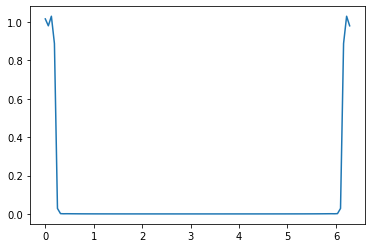

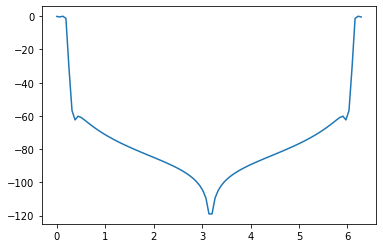

In [85]:
plt_fft(sinc(3000))
plt_db(sinc(3000))

In order to have something for the later filters to compare with, we apply it to the input:

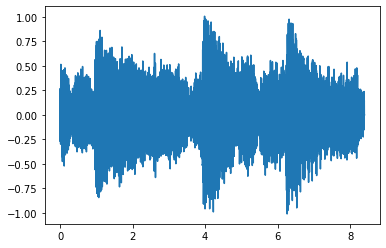

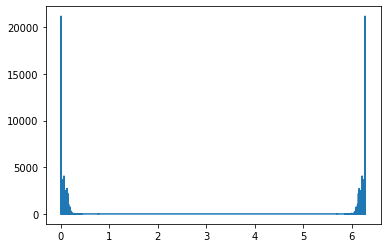

In [63]:
output_sinc = np.convolve(ocean, sinc(3000))
plt_time(output_sinc)
plt_fft(output_sinc)

## The FIR windows

As seen from above, the low-pass filter sampled from `sinc` isn't ideal: there's quite some visible passband ripple and this could distort our output.  Luckily we can improve this by multiply the impulse response with a window, whose functions are provided by `scipy`!

In [0]:
from scipy.signal import windows


def fir(limit, window, length=101):
    """Return a low-pass filter using the specified windowing technique."""
    return getattr(windows, window)(length) * sinc(limit, length)

We first try the Bartlett window:

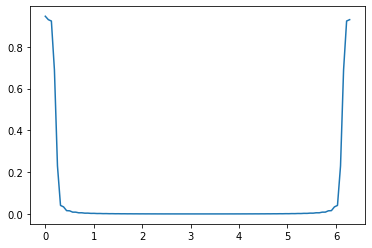

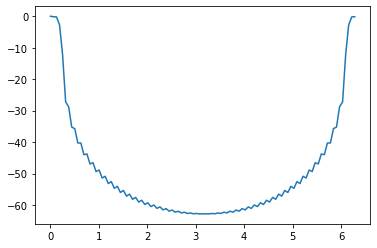

In [89]:
bartlett = fir(3000, 'bartlett')
plt_fft(bartlett)
plt_db(bartlett)

Considering only the plot in dB, this seems to be worse than the vanila sinc samples.  Next, we try the Hamming window:

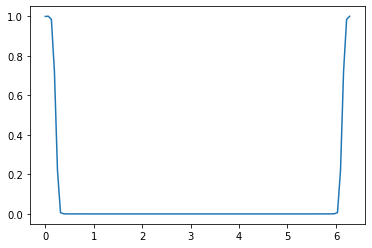

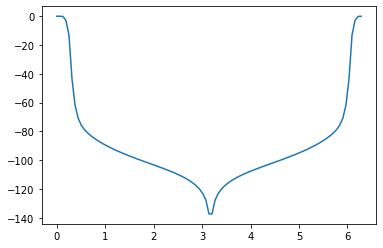

In [90]:
hamming = fir(3000, 'hamming')
plt_fft(hamming)
plt_db(hamming)

The Hamming window seems to provide a smoother filter (i.e. almost no ramples); other than that it's quite equivalent to the original filter.

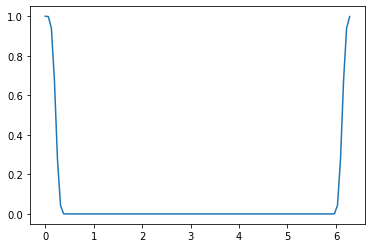

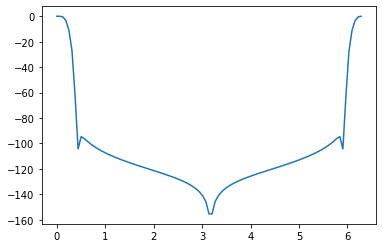

In [91]:
blackman = fir(3000, 'blackman')
plt_fft(blackman)
plt_db(blackman)

The Blackman seems to provide a slightly better result, with the gain dropping noticiably faster in the transition bandwidth.

There is very little point ploting the output signal however, since the original is already too complicated for human eyes.  Pretty much all we will see is very similar to that of the vanila sinc samples.  Instead, we write the output to files and listen to them instead:

In [0]:
def write(signal, filename):
    """Write the given signal to the corresponding filename."""
    with wave.open(f'{filename}.wav', 'w') as wav:
        wav.setnchannels(1)
        wav.setsampwidth(sample_width)
        wav.setframerate(frame_rate)
        width = sample_width << 3
        wav.writeframesraw(getattr(np, f'int{width}')(signal * 2**(width - 1)))


write(np.convolve(ocean, sinc(3000)), 'output_sinc')
write(np.convolve(ocean, bartlett), 'output_bartlett')
write(np.convolve(ocean, hamming), 'output_hamming')
write(np.convolve(ocean, blackman), 'output_blackman')

After a quick listen, `output_{sinc,bartlett}` seems to have better soundstage than the other two, which means Hamming and Blackman does better jobs filtering *away* high frequencies.  `output_hamming` seems to be the most *dull* to me, which means it's the best filtered one.



## The IIR filters

In this section, we are going to examine a few IIR filters.  Before we start, let's define a thin wrapper for convenience:

In [0]:
from scipy import signal


def iir(limit, design, order=4):
    """Return the specified IIR filter."""
    if design == 'cheby1': return signal.cheby1(order, 1, limit/frame_rate)
    return getattr(signal, design)(order, limit/frame_rate)


def plt_iir(b, a):
    """Plot the given IIR filter in linear as well as log (dB) magnitude."""
    w, h = signal.freqz(b, a)
    plt.plot(w, abs(h))
    plt.show()
    plt.plot(w, 20*np.log10(abs(h)))
    plt.show()


def apply_iir(data, b, a):
    """Apply the given IIR filter to data."""
    return signal.lfilter(b, a, data)

We can then respectively plot the Chebyshev, Butterworth and Bessel filters in frequency domain:


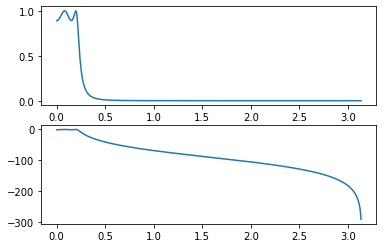

In [108]:
cheby1 = iir(3000, 'cheby1')
plt_iir(*cheby1)

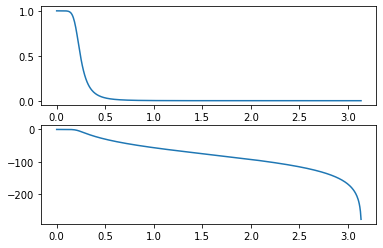

In [110]:
butter = iir(3000, 'butter')
plt_iir(*butter)

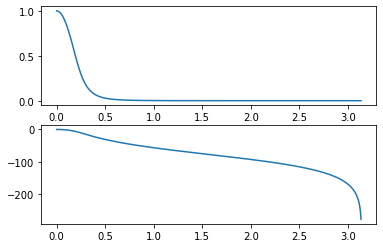

In [109]:
bessel = iir(3000, 'bessel')
plt_iir(*bessel)

We then apply these to the input a pay listen:

In [0]:
write(apply_iir(ocean, *cheby1), 'output_chebyshev')
write(apply_iir(ocean, *butter), 'output_butterworth')
write(apply_iir(ocean, *bessel), 'output_bessel')

As shown in the frequency domain, these filters are not as effective as the ones we discovered in FIR, at least using the configurations above.  The outputs sound a lot clearer which indicates some higher frequency sounds excapes from the filters.